In [1]:
import torch
from torchvision.transforms import functional
import torch.nn.functional as tnf
from torchvision import transforms
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN

## Recadrage des images

Taille attendue : 200x200 + conversion en niveaux de gris.

In [2]:
def preprocess_image(image, target_size=(200, 200), crop="lower", left_offset=0, top_offset=0):
    """
    Prétraite une image en la convertissant en nuances de gris, puis en la redimensionnant et la recadrant selon les paramètres donnés.
    :param image: Image à traiter
    :param target_size: Taille cible de l'image
    :param crop: Position du crop (lower ou center)
    :param left_offset: Décalage à appliquer à gauche
    :param top_offset: Décalage à appliquer en haut
    """

    # Convertir en nuances de gris
    image_gray = functional.to_grayscale(image, num_output_channels=1)

    # Caclul des différences de taille entre l'image et la taille cible
    width, height = image_gray.size
    width_delta = (width - target_size[0])
    height_delta = (height - target_size[1])

    # L'image est centrée dans sa longueur, on calcule le crop à appliquer (floor et ceil pour corriger les erreurs d'arrondi)
    left = math.floor(width_delta / 2)
    right = math.ceil(width - width_delta / 2)

    # L'image peut être centrée ou plaquée sur le bas (afin de garder au maximum la ligne blanche)
    if crop == "lower":
        top = height_delta
        bottom = height
    else:
        top = math.floor(height_delta / 2)
        bottom = math.ceil(height - height_delta / 2)

    # Calcul du crop final et applique l'offset si besoin
    crop = (left + left_offset, top + top_offset, right + left_offset, bottom + top_offset)
    return image_gray.crop(crop)

In [3]:
def plot_images(img1, img2, img3, title1="Image 1", title2="Image 2", title3="Image 3", img1_cmap=None, img2_cmap=None, img3_cmap=None):
    """
    Affiche 2 images côte à côte
    :param img1: Image de gauche
    :param img2: Image du milieu
    :param img3: Image de droite
    :param title1: Titre de l'image de gauche
    :param title2: Titre de l'image du milieu
    :param title3: Titre de l'image de droite
    :param img1_cmap: Colormap de l'image de gauche
    :param img2_cmap: Colormap de l'image du milieu
    :param img3_cmap: Colormap de l'image de droite
    """
    _, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(img1, cmap=img1_cmap)
    ax[0].set_title(title1)
    ax[0].axis("off")
    ax[1].imshow(img2, cmap=img2_cmap)
    ax[1].set_title(title2)
    ax[1].axis("off")
    ax[2].imshow(img3, cmap=img3_cmap)
    ax[2].set_title(title3)
    ax[2].axis("off")
    plt.show()

## Filtre de Sobel

In [4]:
# Définir les noyaux Sobel pour les dérivées horizontales et verticales
vert_values = [3., 6.]
sobel_kernel_x = torch.tensor([[-vert_values[0], 0., vert_values[0]],
                               [-vert_values[1], 0., vert_values[1]],
                               [-vert_values[0], 0., vert_values[0]]])

horz_values = [1., 2.]
sobel_kernel_y = torch.tensor([[-horz_values[0], -horz_values[1], -horz_values[0]],
                               [0., 0., 0.],
                               [horz_values[0], horz_values[1], horz_values[0]]])

# Ces noyaux doivent être étendus pour s'adapter aux dimensions de l'image [batch_size, channels, height, width]
# [out_channels, in_channels, height, width]
sobel_kernel_x = sobel_kernel_x.view((1, 1, 3, 3))
sobel_kernel_y = sobel_kernel_y.view((1, 1, 3, 3))

# Vérifiez si CUDA est disponible et définissez le périphérique en conséquence
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convertir les noyaux en types de données adaptés pour les calculs de convolution
sobel_kernel_x = sobel_kernel_x.to(device, dtype=torch.float32)
sobel_kernel_y = sobel_kernel_y.to(device, dtype=torch.float32)

# Fonction pour appliquer le filtre Sobel à une image
def sobel_filter(preprocessed_image, magnitude_threshold=0.5, y_threshold=50):
    # Convertir l'image en tenseur PyTorch
    transform = transforms.ToTensor()
    image_tensor = transform(preprocessed_image).to(device)
    
    # Ajouter des dimensions de batch et de canal pour correspondre à la forme [B, C, H, W]
    image_tensor = image_tensor.unsqueeze(0)

    # Appliquer le filtre de Sobel sur l'image tensorielle
    Gx = tnf.conv2d(image_tensor, sobel_kernel_x, padding=1)
    Gy = tnf.conv2d(image_tensor, sobel_kernel_y, padding=1)

    # Calculer la magnitude du gradient
    sobel_magnitude = torch.sqrt(Gx**2 + Gy**2)

    # Appliquer un seuillage pour binariser l'image
    sobel_binary = torch.where(sobel_magnitude > magnitude_threshold, torch.tensor(1.0), torch.tensor(0.0))

    # Rendre les pixels dont la coordonnée y est supérieure à y_threshold noirs
    sobel_binary[:, :, :y_threshold:, :] = 0.0

    # Créer un masque pour fixer les pixels tout à gauche, tout à droite et tout en bas de l'image en noir
    sobel_binary[:, :, :, :1] = 0.0  # Fixer les pixels tout à gauche de l'image
    sobel_binary[:, :, :, -1:] = 0.0  # Fixer les pixels tout à droite de l'image
    sobel_binary[:, :, -1:, :] = 0.0  # Fixer les pixels tout en bas de l'image
    
    # Convertir le gradient en image PIL pour l'affichage
    sobel_magnitude_image = transforms.ToPILImage()(sobel_binary.squeeze(0))
    
    return sobel_magnitude_image

## Détection de lignes

Pour cela, on utilise DBSCAN pour trouver les lignes en fonction de la proximité des pixels de bords qui ont été détectés par le filtre de Sobel.

In [5]:
def compute_center_point(points, y_min, y_max, y_true):
    return (int(np.array([point for point in points if y_min <= point[1] <= y_max]).mean(axis=0)[0]), y_true)

In [6]:
def detect_lines(sobel_image, y_offset=50, eps=5, min_samples=10):
    # Créer une liste pour stocker les points de bordure
    points = []
    for x in range(sobel_image.size[0]):
        for y in range(sobel_image.size[1]):
            if sobel_image.getpixel((x, y)) == 255:
                points.append((x, y))

    # Utilisation de DBSCAN pour détecter les lignes
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(points)

    detected_points = []

    # Récupère les clusters et compte le nombre de points dans chaque cluster
    unique, counts = np.unique(clusters, return_counts=True)
    for label in unique:
        if label == unique[np.argmax(counts)]: # On ne garde que le cluster le plus grand
            cluster_points = np.array(points)[clusters == label]
            detected_points.append(cluster_points)

    for line in detected_points:
        plt.scatter(line[:, 0], line[:, 1])
        plt.gca().invert_yaxis()
        plt.title("Detected lines")
        plt.xlim(0, 200)
        plt.ylim(200, 0)
        plt.show()

    point_A = compute_center_point(detected_points[0], 185, 195, 200)

    min_value_y = detected_points[0].min(axis=0)[1]
    y_B = 200 - y_offset
    if y_B < min_value_y:
        y_B = min_value_y
        print("Warning: y_max - y_offset < y_min. y_offset is set to y_min")

    point_B = compute_center_point(detected_points[0], y_B - 5, y_B + 5, y_B)

    return point_A, point_B

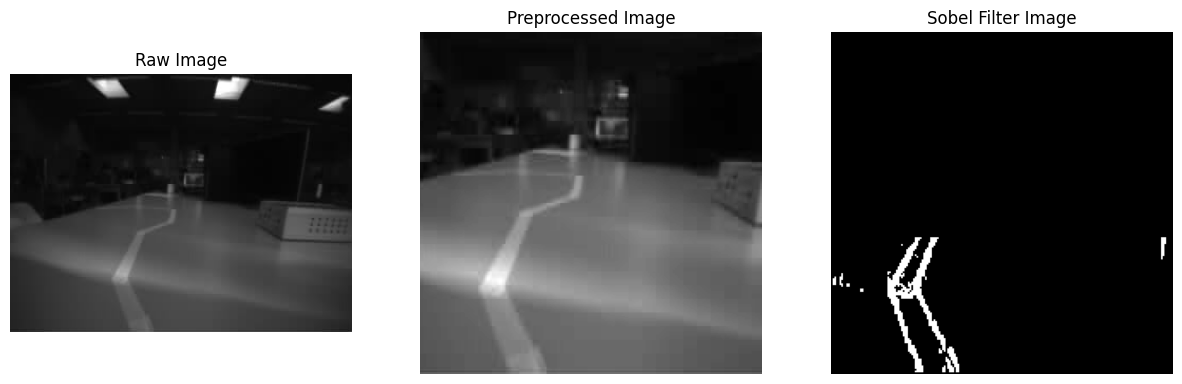

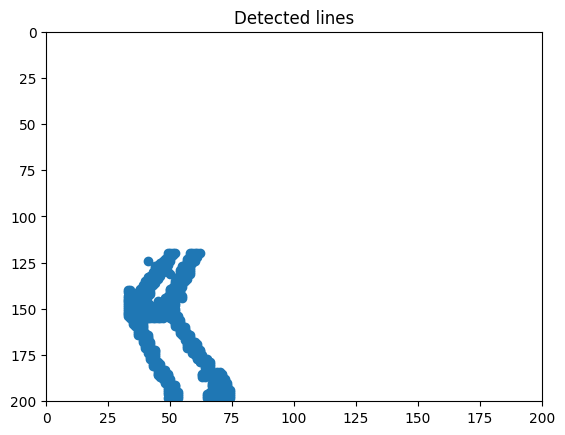

In [18]:
img_number = 5
test_image_path = './scotch/img' + str(img_number) + '.png'

raw_image = Image.open(test_image_path) # Charger l'image venant du drone
resized_image = preprocess_image(raw_image) # Redimensionne et convertit l'image en nuances de gris
sobel_image = sobel_filter(resized_image, magnitude_threshold=0.25, y_threshold=120) # Applique le filtre de Sobel pour détecter les lignes

plot_images(raw_image, resized_image, sobel_image, "Raw Image", "Preprocessed Image", "Sobel Filter Image", img1_cmap=None, img2_cmap="gray", img3_cmap="gray")

point_A, point_B = detect_lines(sobel_image, y_offset=50, eps=5, min_samples=20) # Détecte les lignes et place les points A et B

In [8]:
point_A, point_B

((60, 200), (42, 150))

## Test complet

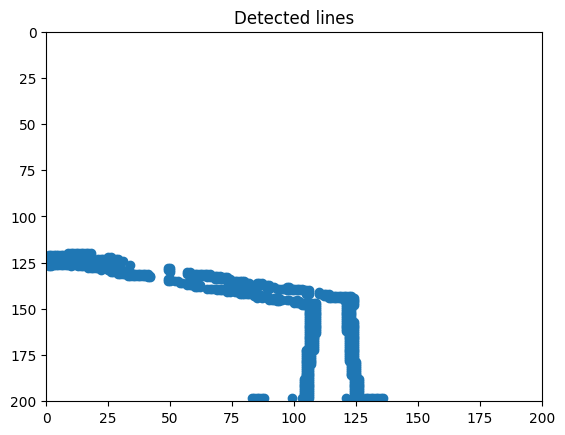

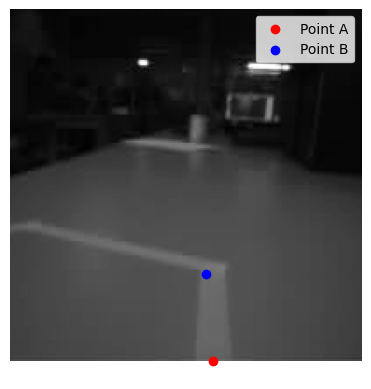

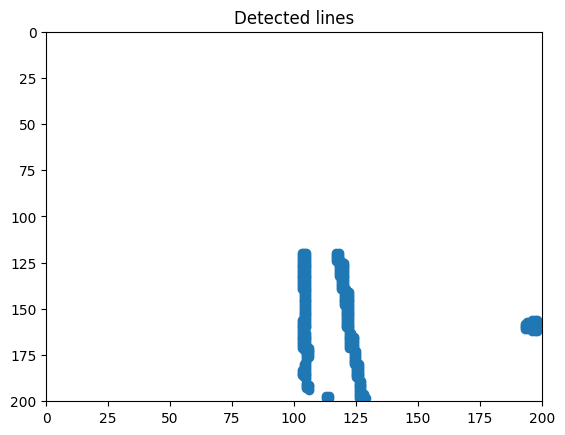

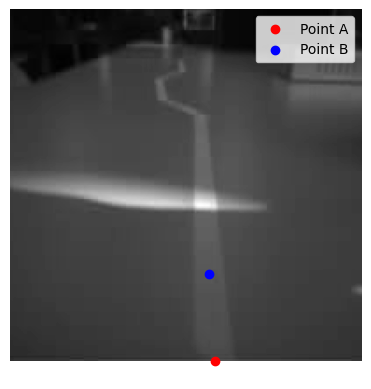

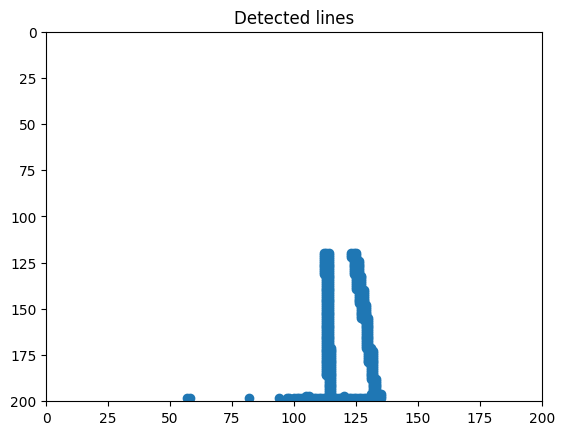

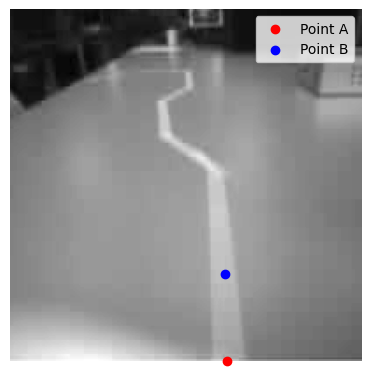

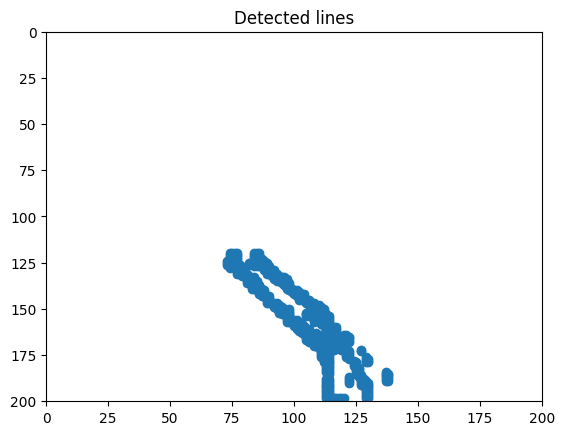

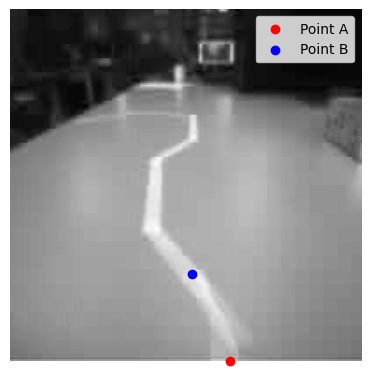

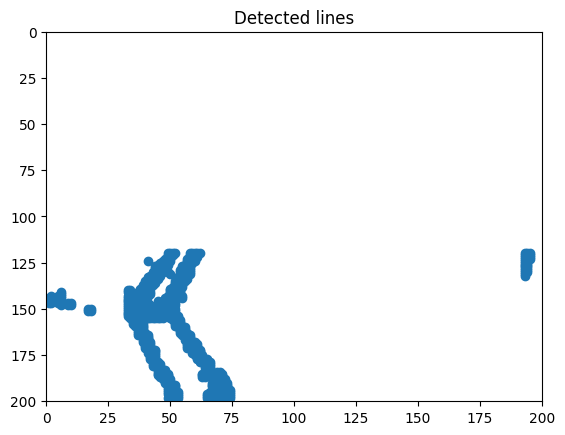

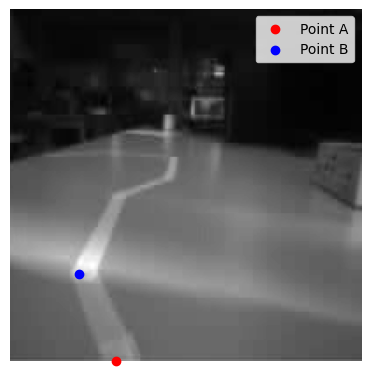

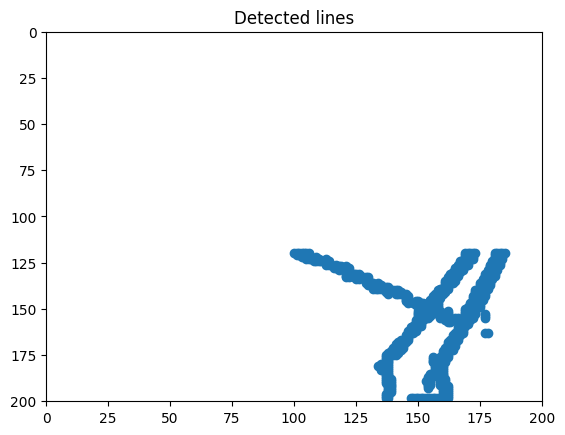

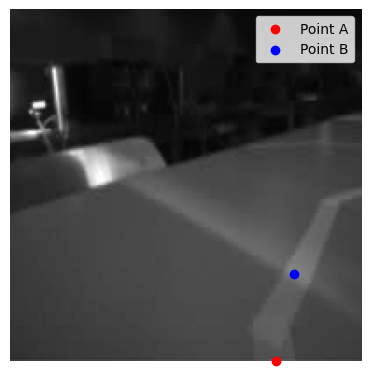

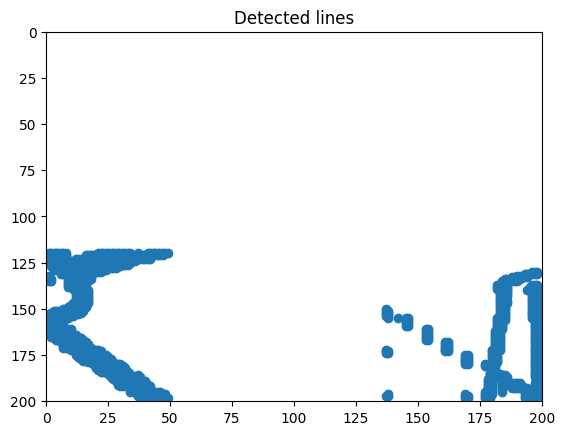

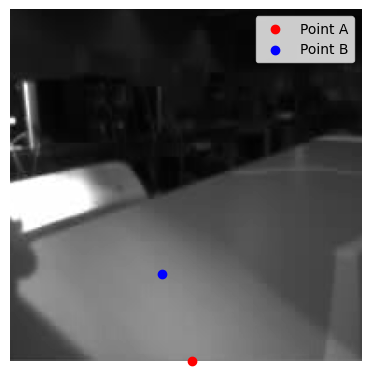

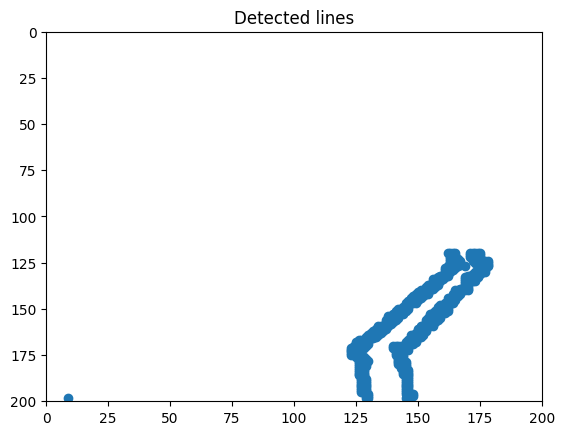

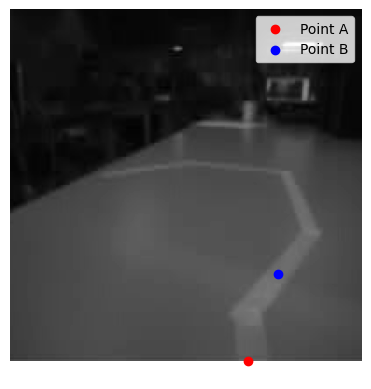

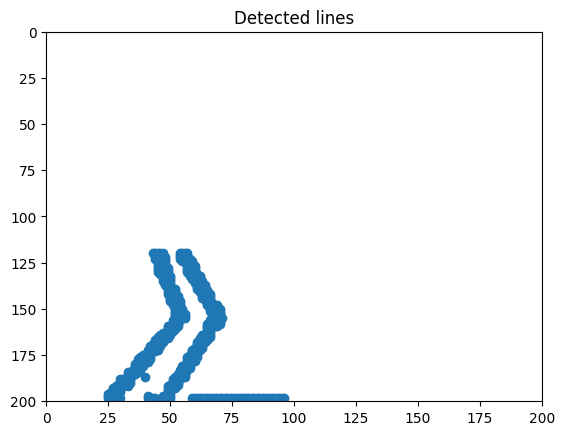

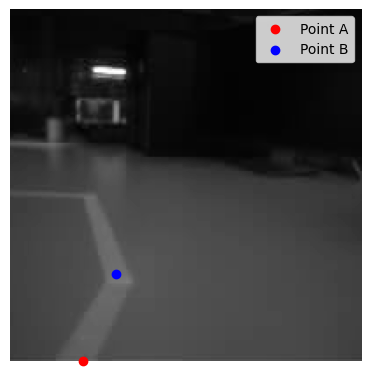

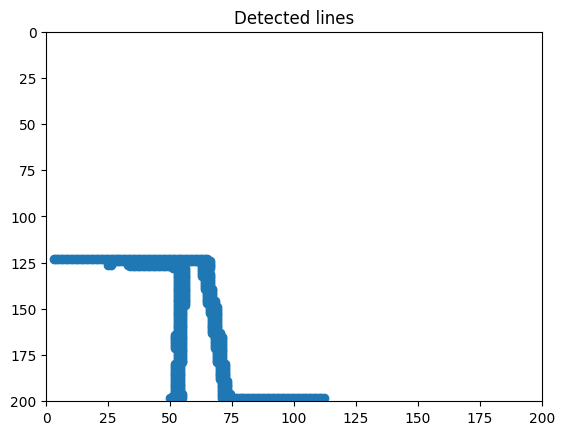

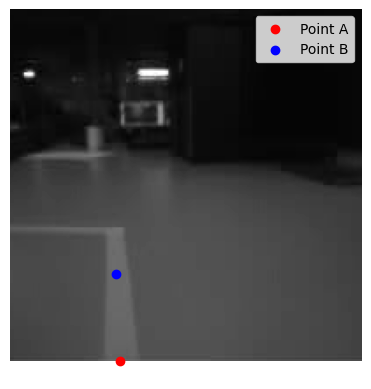

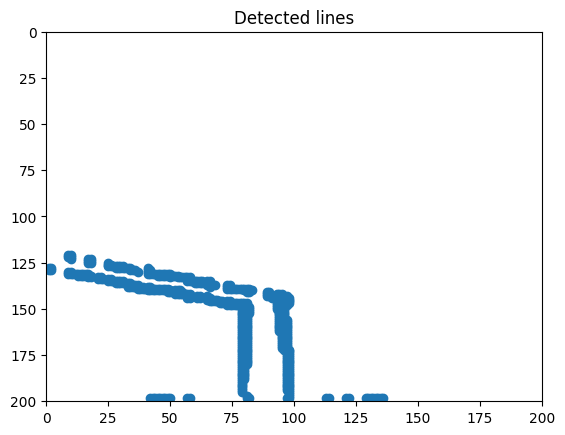

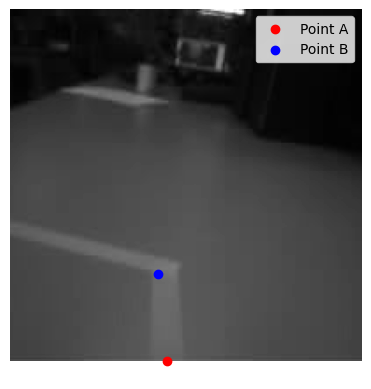

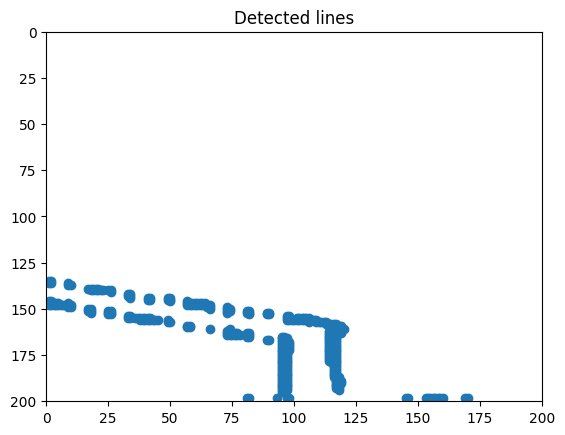

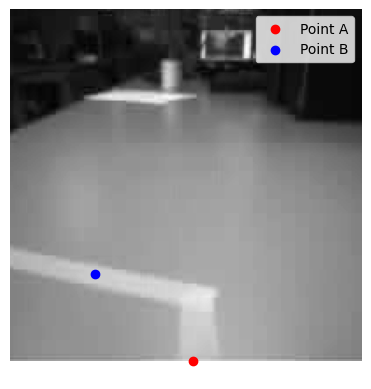

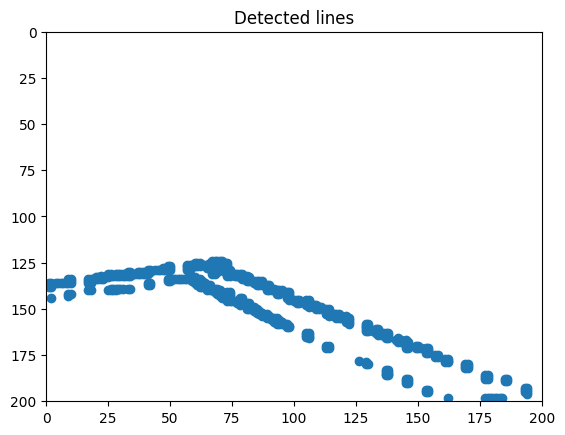

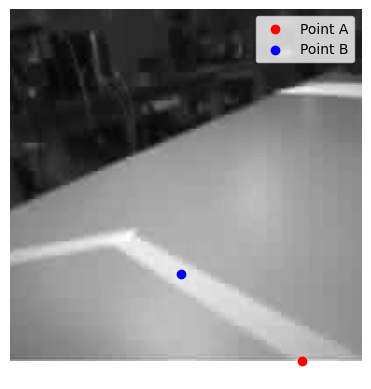

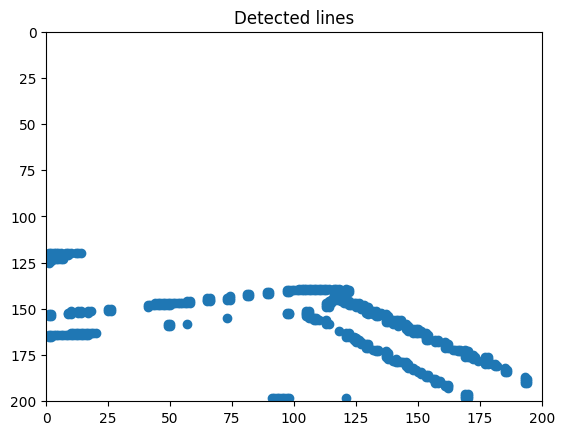

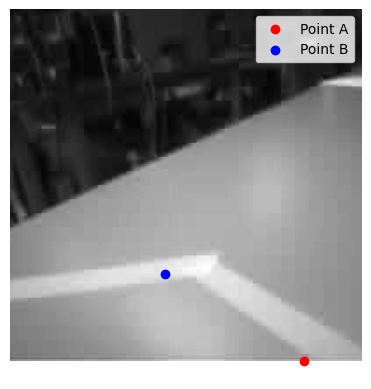

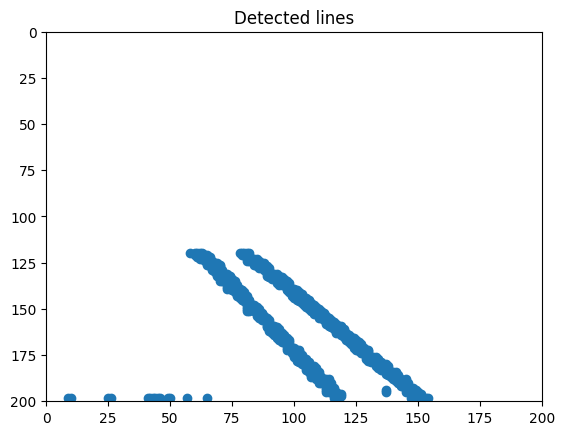

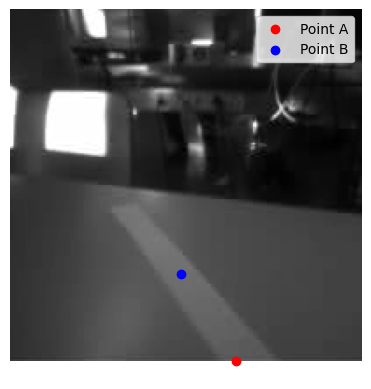

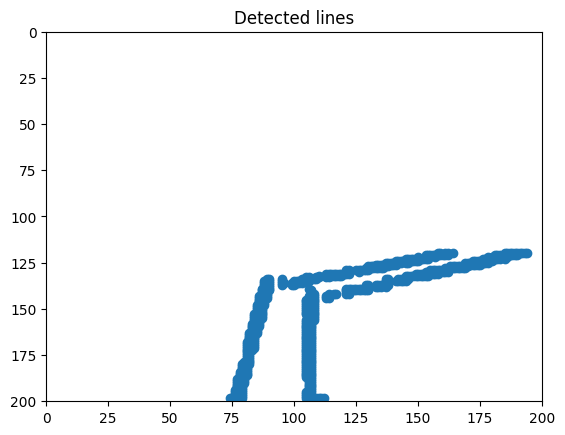

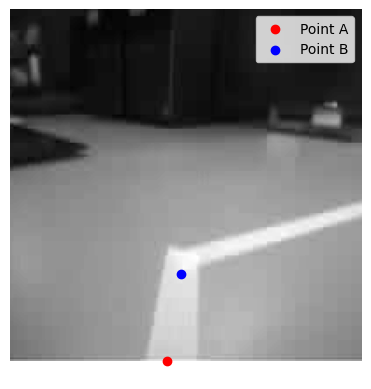

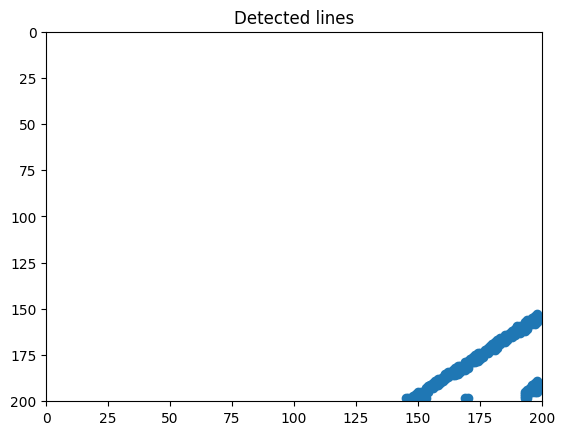

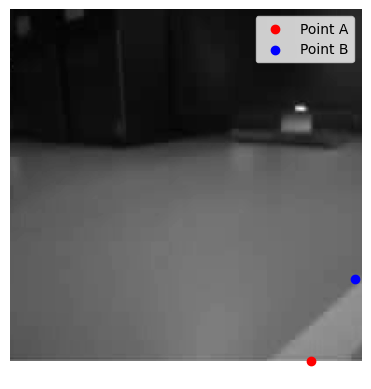

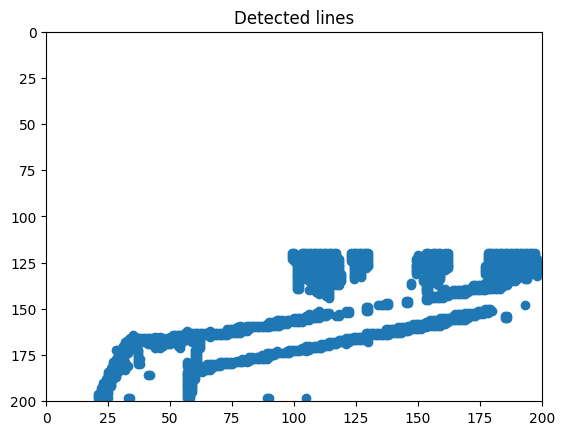

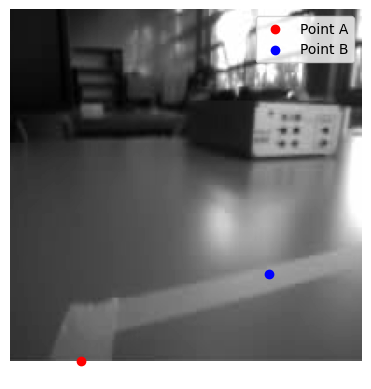

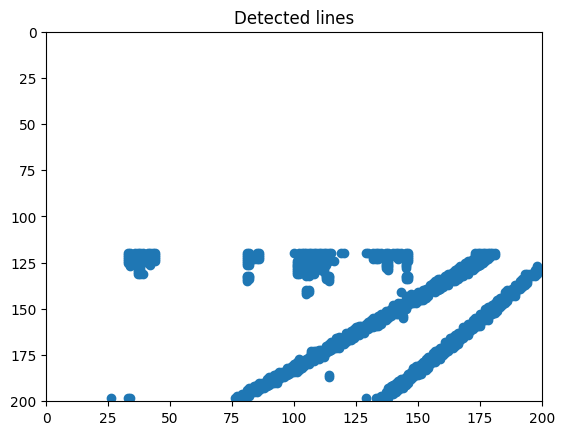

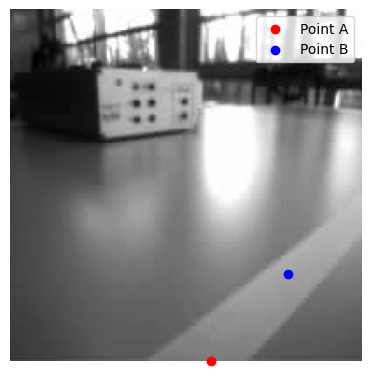

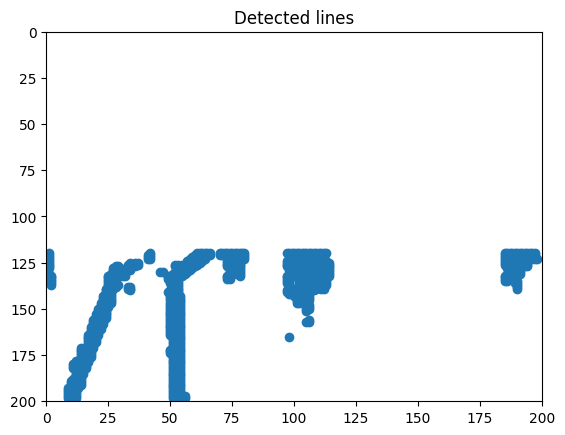

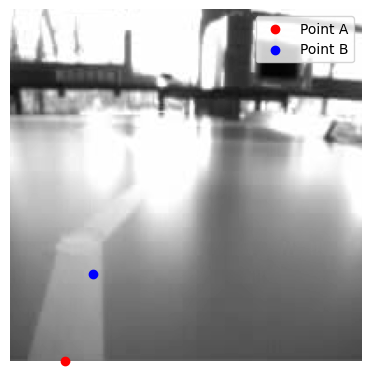

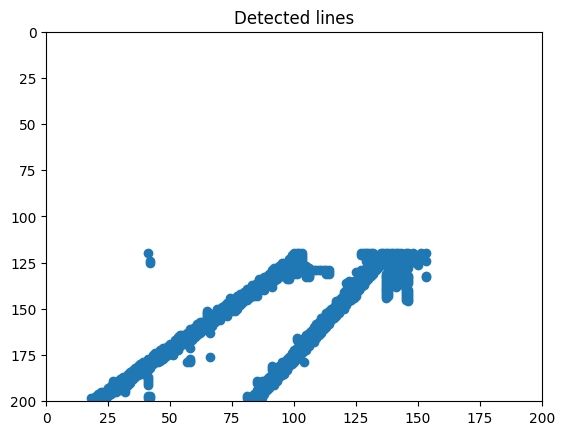

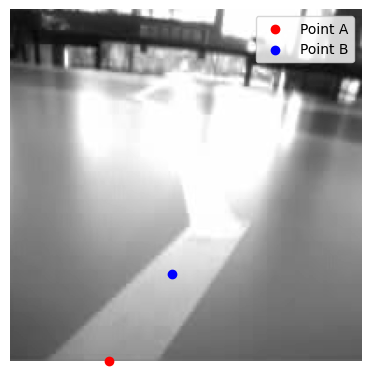

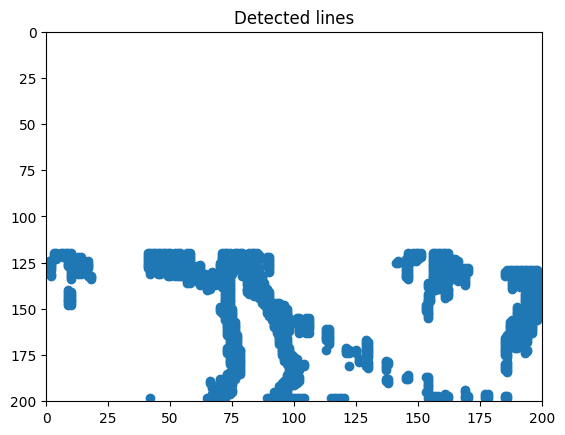

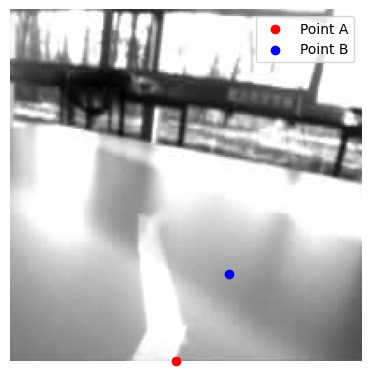

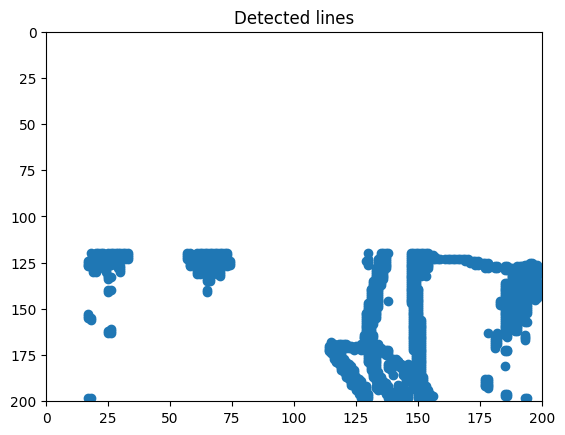

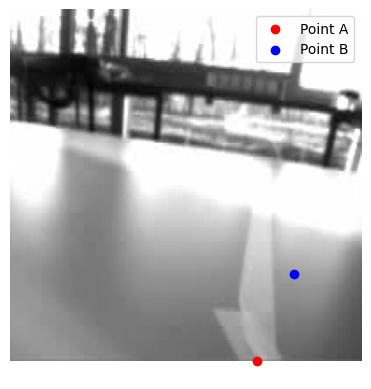

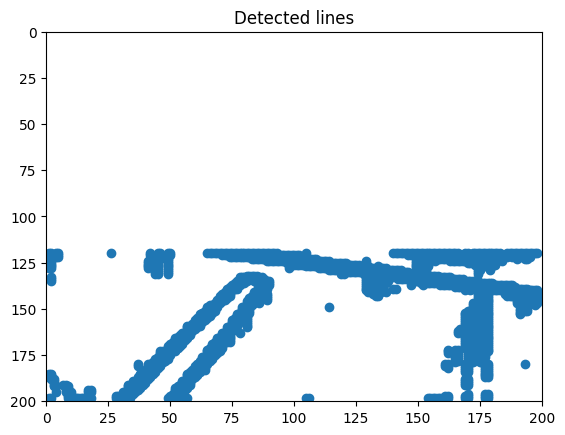

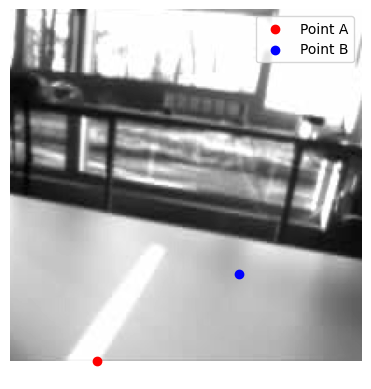

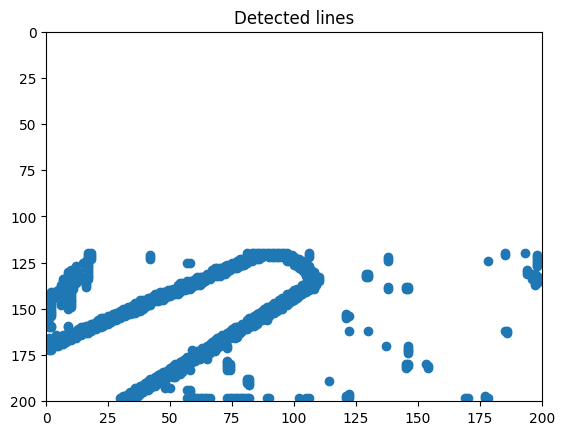

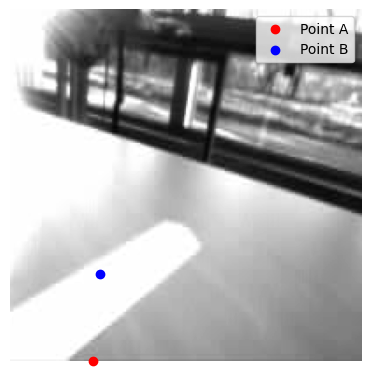

In [19]:
for i in range(1, 26):
    # Charger l'image
    image = Image.open(f"./scotch/img{i}.png")

    # Prétraiter l'image
    resized_image = preprocess_image(image, target_size=(200, 200), crop="lower", left_offset=0, top_offset=0)

    # Appliquer le filtre de Sobel
    sobel_image = sobel_filter(resized_image, magnitude_threshold=0.25, y_threshold=120)

    # Détecter les lignes
    point_A, point_B = detect_lines(sobel_image, y_offset=50, eps=1, min_samples=20)

    # Afficher les points A et B sur l'image
    plt.imshow(resized_image, cmap="gray")
    plt.scatter(point_A[0], point_A[1], c='r', label='Point A')
    plt.scatter(point_B[0], point_B[1], c='b', label='Point B')
    plt.legend()
    plt.axis("off")
    plt.show()

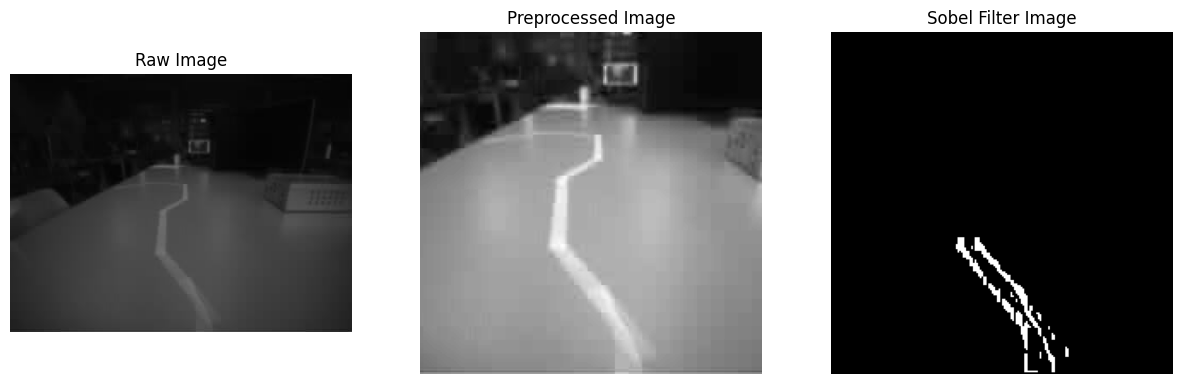

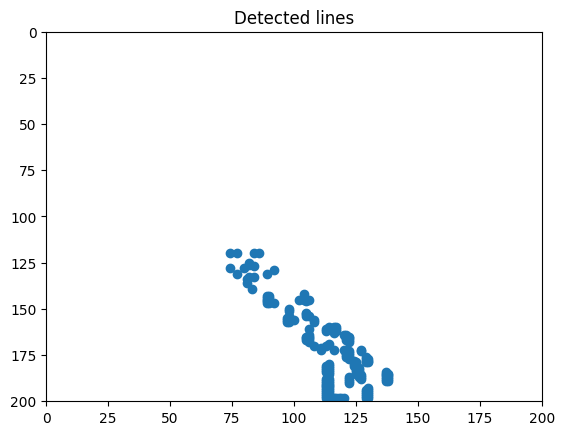

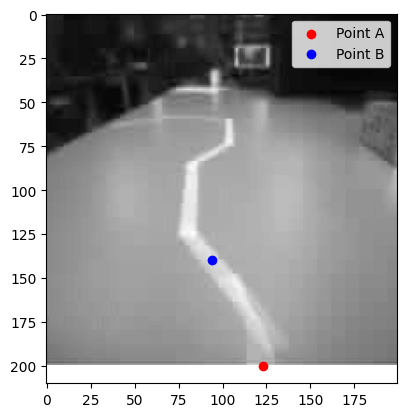

In [10]:
img_number = 4
test_image_path = './scotch/img' + str(img_number) + '.png'

raw_image = Image.open(test_image_path) # Charger l'image venant du drone
resized_image = preprocess_image(raw_image) # Redimensionne et convertit l'image en nuances de gris
sobel_image = sobel_filter(resized_image, magnitude_threshold=0.25, y_threshold=120) # Applique le filtre de Sobel pour détecter les lignes

plot_images(raw_image, resized_image, sobel_image, "Raw Image", "Preprocessed Image", "Sobel Filter Image", img1_cmap=None, img2_cmap="gray", img3_cmap="gray")

point_A, point_B = detect_lines(sobel_image, y_offset=60, eps=1, min_samples=5) # Détecte les lignes et place les points A et B

# Afficher les points A et B sur l'image
plt.imshow(resized_image, cmap="gray")
plt.scatter(point_A[0], point_A[1], c='r', label='Point A')
plt.scatter(point_B[0], point_B[1], c='b', label='Point B')
plt.legend()
plt.show()